<a href="https://colab.research.google.com/github/AshnakAGQ/DistractedDriver/blob/master/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

##Tensorflow

In [1]:
!pip install tf-nightly
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt

     |████████████████████████████████| 350.0MB 22kB/s 
     |████████████████████████████████| 460kB 53.1MB/s 
     |████████████████████████████████| 3.0MB 50.4MB/s 


In [0]:
print(tf.__version__)

2.3.0-dev20200610


##Google Drive

In [88]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Kaggle

In [3]:
!pip install kaggle
import os # Sets the environment variables in the root folder 
os.environ['KAGGLE_USERNAME'] = "unorna"
os.environ['KAGGLE_KEY'] = "0a21e3dad74e374d7054ac533a76ede3"
import kaggle
kaggle.api.authenticate()
kaggle.api.competition_download_files('state-farm-distracted-driver-detection', path = 'data/DistractedDriver')
!unzip -q data/DistractedDriver/state-farm-distracted-driver-detection.zip  #unzips kaggle data into content/data

#Import image data


In [80]:
from tensorflow.python.ops import image_ops
from tensorflow.python.data.ops import dataset_ops
from tensorflow.python.ops import io_ops
import os
import numpy as np

def path_to_image(path, image_size, num_channels, interpolation):
  img = io_ops.read_file(path)
  img = image_ops.decode_image(
      img, channels=num_channels, expand_animations=False)
  img = image_ops.resize_images_v2(img, image_size, method=interpolation)
  img.set_shape((image_size[0], image_size[1], num_channels))
  return img
  
dataset = tf.data.Dataset.list_files("/path/*.txt")
filenames = []
for path, subdirs, files in os.walk('/content/imgs/test/'):
  filenames += files
#print(filenames)

filename_ds = tf.data.Dataset.from_tensor_slices(filenames)
path_ds = filename_ds.map(
    lambda x: "/content/imgs/test/" + x)


image_size = (224, 224) #image size for image net is 224 x 224 x 3
num_channels = 3
batch_size = 32
interpolation = 'bilinear'

full_ds = path_ds.map(
    lambda x: path_to_image(x, image_size, num_channels, interpolation))
full_ds = dataset_ops.Dataset.zip((full_ds, filename_ds))
full_ds = full_ds.batch(batch_size)

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=string, numpy=b'/content/imgs/test/img_94469.jpg'>>


##View Data

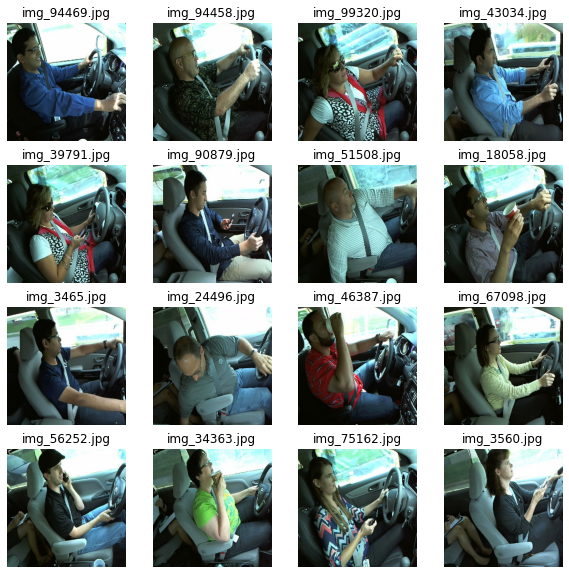

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in full_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy().decode("utf-8") )
        plt.axis("off")

#Test Model

##Frozen VGG16

In [0]:
vgg_model = keras.models.load_model('/content/drive/My Drive/CS 175 Models/frozen_vgg16_model.h5')
def VGG_preprocess(image,score):
  image = keras.applications.vgg16.preprocess_input(image)
  if score is None:
        return image
  else:
        return image, score

test = full_ds.map(VGG_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test.prefetch(tf.data.experimental.AUTOTUNE)

predictions = vgg_model.predict(test)

##Frozen Resnet

In [0]:
res_model = keras.models.load_model('/content/drive/My Drive/CS 175 Models/frozenresnetmodel.h5')
def Resnet_preprocess(image,score):
  image = keras.applications.resnet50.preprocess_input(image)
  if score is None:
        return image
  else:
        return image, score

test = full_ds.map(Resnet_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test.prefetch(tf.data.experimental.AUTOTUNE)

predictions = res_model.predict(test)

##Unfrozen Inception

In [0]:
inc_model = keras.models.load_model('/content/drive/My Drive/CS 175 Models/unfrozen_inceptionv3_model.h5')
def Inception_preprocess(image,score):
  image = keras.applications.inception_v3.preprocess_input(image)
  if score is None:
        return image
  else:
        return image, score

test = full_ds.map(Inception_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test.prefetch(tf.data.experimental.AUTOTUNE)

predictions = inc_model.predict(test)

##Unfrozen Resnet

In [0]:
res_model = keras.models.load_model('/content/drive/My Drive/CS 175 Models/unfrozen_resnet50_model.h5')
def Resnet_preprocess(image,score):
  image = keras.applications.resnet50.preprocess_input(image)
  if score is None:
        return image
  else:
        return image, score

test = full_ds.map(Resnet_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test.prefetch(tf.data.experimental.AUTOTUNE)

predictions = res_model.predict(test)

##Unfrozen VGG16

In [0]:
vgg_model = keras.models.load_model('drive/My Drive/CS 175 Models/unfrozen_vgg16_model.h5')
def VGG_preprocess(image,score):
  image = keras.applications.vgg16.preprocess_input(image)
  if score is None:
        return image
  else:
        return image, score

test = full_ds.map(VGG_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test.prefetch(tf.data.experimental.AUTOTUNE)

predictions = vgg_model.predict(test)

#Create CSV

In [0]:
import pandas as pd

pd1 = pd.DataFrame(filenames, columns=["img"])
pd2 = pd.DataFrame(predictions, columns=[f"c{i}" for i in range(10)])
result = pd.concat([pd1, pd2], axis=1, sort=False)
result.to_csv("results.csv", index=False)
